In [1]:
import pandas as pd
import pysam
from Bio import SeqIO
import re
import os
import subprocess
import matplotlib.pyplot as plt

def parse_read_bases(read_bases):
    """
    Parse read bases to count correct matches (., and ,) while correctly handling indels,
    read starts (^), read ends ($), and skipping over sequences indicating indels (+nXXX or -nXXX).
    """
    # Remove read start markers (^) along with the following character indicating mapping quality
    cleaned_bases = re.sub(r'\^.', '', read_bases)

    # Remove read end markers ($)
    cleaned_bases = cleaned_bases.replace('$', '')

    # Correctly handle indels: remove sequences following + or - indicating the length and actual indel
    cleaned_bases = re.sub(r'[\+\-](\d+)([ACGTNacgtn]+)', '', cleaned_bases)

    # Correctly handle * symbols representing deletions of the reference base (not counted as correct)
    cleaned_bases = cleaned_bases.replace('*', '')

    # After removing all special cases, count '.' and ',' as correct matches
    correct = cleaned_bases.count('.') + cleaned_bases.count(',')

    return correct

def extract_reference_sequences(fasta_file):
    """
    Extract reference sequences from a fasta file.
    
    Args:
    fasta_file (str): Path to the fasta file.
    
    Returns:
    pd.DataFrame: DataFrame with columns ['position', 'sequence'].
    """
    reference_data = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        for i, nucleotide in enumerate(record.seq):
            position = i + 1
            reference_data.append({'position': position, 'sequence': nucleotide})
    
    reference_df = pd.DataFrame(reference_data)
    return reference_df

# Function to extract sequences using samtools faidx and return them as a string
def extract_sequences_as_string(fasta_file, regions):
    sequences = []
    for region in regions:
        cmd = f'/spack/2206/apps/linux-centos7-x86_64_v3/gcc-11.3.0/samtools-1.17-fq34dvu/bin/samtools faidx {fasta_file} {region}'
        result = subprocess.run(cmd, stdout=subprocess.PIPE, shell=True)
        sequences.append(result.stdout.decode('utf-8'))
    return sequences

def longest_consecutive_ns(sequence):
    max_count = 0
    current_count = 0
    
    for base in sequence:
        if base == 'N':
            current_count += 1
            if current_count > max_count:
                max_count = current_count
        else:
            current_count = 0
    
    return max_count


In [2]:
with open('/home1/zhuyixin/zhuyixin_proj/AssmQuality/a.txt', 'r') as file:
    species_list = file.read().splitlines()
    
haploid = False
gene = "IGL"
  
all_species_results = []

# Process each species
for species in species_list:
    dirOut = f"/home1/zhuyixin/zhuyixin_proj/AssmQuality/errorPlots/{species}"
    dirStat = f"/home1/zhuyixin/zhuyixin_proj/AssmQuality/errorStats/{species}"
    pri_pileup_file = f'../errorStats/{species}/{gene}_pri_pileup.txt'

    results_pri = {}  # To store results, keyed by (chromosome, position)
    with open(pri_pileup_file, 'r') as f:
        for line in f:
            chrom, pos, ref_base, depth, read_bases, _ = line.split()[:6]
            correct = parse_read_bases(read_bases)
            if int(depth) > 0:
                percent_correct = (correct / int(depth)) * 100
            else:
                percent_correct = 0
             # Store or process results
            results_pri[(chrom, pos)] = (correct, percent_correct, depth)
    
    pri_p = [(*key, *value) for key, value in results_pri.items()]
    pri_pileup = pd.DataFrame(pri_p, columns=['Chrom', 'Pos', 'Correct', 'PercentCorrect', "Depth"])
    pri_pileup['Pos'] = pd.to_numeric(pri_pileup['Pos'])
    pri_pileup['Correct'] = pd.to_numeric(pri_pileup['Correct'])
    pri_pileup['PercentCorrect'] = pd.to_numeric(pri_pileup['PercentCorrect'])
    pri_pileup['Depth'] = pd.to_numeric(pri_pileup['Depth'])
    pri_pileup.sort_values(by=['Chrom', 'Pos'], inplace=True)
    alt_pileup_file = f'../errorStats/{species}/{gene}_alt_pileup.txt'
    if os.path.exists(alt_pileup_file):
        haploid = False
        results_alt = {}  # To store results, keyed by (chromosome, position)
        with open(alt_pileup_file, 'r') as f:
            for line in f:
                chrom, pos, ref_base, depth, read_bases, _ = line.split()[:6]
                correct = parse_read_bases(read_bases)
                if int(depth) > 0:
                    percent_correct = (correct / int(depth)) * 100
                else:
                    percent_correct = 0
                 # Store or process results
                results_alt[(chrom, pos)] = (correct, percent_correct, depth)
        alt_p = [(*key, *value) for key, value in results_alt.items()]
        alt_pileup = pd.DataFrame(alt_p, columns=['Chrom', 'Pos', 'Correct', 'PercentCorrect', "Depth"])
        alt_pileup['Pos'] = pd.to_numeric(alt_pileup['Pos'])
        alt_pileup['Correct'] = pd.to_numeric(alt_pileup['Correct'])
        alt_pileup['PercentCorrect'] = pd.to_numeric(alt_pileup['PercentCorrect'])
        alt_pileup['Depth'] = pd.to_numeric(alt_pileup['Depth'])
        alt_pileup.sort_values(by=['Chrom', 'Pos'], inplace=True)
    else:
        haploid = True
    if not haploid :
        pileup = pd.concat([pri_pileup, alt_pileup])
    else:
        pileup = pri_pileup
    pileup.sort_values(by=['Chrom', 'Pos'], inplace=True)
    low_coverage = pileup[pileup['Depth'] <= 2]
    
    low_coverage['group'] = low_coverage.groupby('Chrom')['Pos'].transform(lambda x: (x.diff() > 2).cumsum())
    
    # Now, for each group, we can identify the start and end of continuous regions
    break_regions = low_coverage.groupby(['Chrom', 'group']).agg({'Pos': ['min', 'max']}).reset_index()
    
    # Renaming for clarity
    break_regions.columns = ['Chrom', 'group', 'Start', 'End']
    break_regions.drop('group', axis=1, inplace=True)
    break_regions_list = [f"{row['Chrom']}:{row['Start']}-{row['End']}" for index, row in break_regions.iterrows()]

    reference_fasta_file = f"/home1/zhuyixin/zhuyixin_proj/AssmQuality/assemblies/{species}.merged.fasta"
    extracted_sequences = extract_sequences_as_string(reference_fasta_file, break_regions_list)
    classifications = ['non-N low coverage',
                       'N low coverage',
                       'non-N gap',
                       'N gap']
    
    for i in range(len(extracted_sequences)):
        if longest_consecutive_ns(extracted_sequences[i]) > 5:
            N = True
        else:
            N = False
        minCov = pileup[(pileup['Chrom'] == break_regions_list[i].split(':')[0]) & (pileup['Pos'] >= int(break_regions_list[i].split(':')[1].split('-')[0])) & (pileup['Pos'] <= int(break_regions_list[i].split(':')[1].split('-')[1]))]['Depth'].min()
        if minCov == 0:
            gap = True
        else:
            gap = False
        if N and gap:
            break_regions.loc[i, 'classification'] = classifications[3]
        elif N and not gap:
            break_regions.loc[i, 'classification'] = classifications[2]
        elif not N and gap:
            break_regions.loc[i, 'classification'] = classifications[0]
        else:
            break_regions.loc[i, 'classification'] = classifications[1]
        break_regions.loc[i, 'N'] = N
        break_regions.loc[i, 'Gap'] = gap
    break_regions['Species'] = species
    if not break_regions.empty:
        all_species_results.append(break_regions)

    

/tmp/SLURM_23538498/ipykernel_6543/2219159362.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_coverage['group'] = low_coverage.groupby('Chrom')['Pos'].transform(lambda x: (x.diff() > 2).cumsum())
/tmp/SLURM_23538498/ipykernel_6543/2219159362.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_coverage['group'] = low_coverage.groupby('Chrom')['Pos'].transform(lambda x: (x.diff() > 2).cumsum())
/tmp/SLURM_23538498/ipykernel_6543/2219159362.py:64: SettingWithCopyWarning: 
A value is trying to be 

In [3]:
non_empty_dfs = [df for df in all_species_results if not df.empty]
final_df = pd.concat(non_empty_dfs, ignore_index=True)
def reassign_classification(row):
    if row['N'] and row['Gap']:
        return 'N gap'
    elif row['N'] and not row['Gap']:
        return 'N low coverage'
    elif not row['N'] and row['Gap']:
        return 'non-N gap'
    else:
        return 'non-N low coverage'

# Apply the function to reassign the classification
final_df['classification'] = final_df.apply(reassign_classification, axis=1)

final_df.to_csv(f"/home1/zhuyixin/zhuyixin_proj/AssmQuality/break/{gene}.csv", index=False)

In [2]:
igh = pd.read_csv("/home1/zhuyixin/zhuyixin_proj/AssmQuality/break/IGH.csv", sep=",")
igk = pd.read_csv("/home1/zhuyixin/zhuyixin_proj/AssmQuality/break/IGK.csv", sep=",")
igl = pd.read_csv("/home1/zhuyixin/zhuyixin_proj/AssmQuality/break/IGL.csv", sep=",")
igh

,Chrom,Start,End,classification,N,Gap,Species
0,SUPER_6,5230323,5231771,N gap,True,True,mApoSyl1
1,SUPER_6,6227955,6228415,non-N low coverage,False,False,mApoSyl1
2,SUPER_6,6587326,6587362,non-N low coverage,False,False,mApoSyl1
3,SUPER_6,7811858,7812596,non-N low coverage,False,False,mApoSyl1
4,SUPER_6,8376710,8379507,N gap,True,True,mApoSyl1
...,...,...,...,...,...,...,...
80,SUPER_Z,132716160,132716262,non-N low coverage,False,False,rVipLat1
81,SUPER_Z,5406885,5407029,non-N low coverage,False,False,rVipUrs1
82,SUPER_Z,5580332,5580531,N low coverage,True,False,rVipUrs1
83,SUPER_Z,5771200,5774573,non-N low coverage,False,False,rVipUrs1


In [28]:
meta = pd.read_csv("../species_metainfo.csv", sep=",")
igh_meta = meta.merge(igh, left_on='IndividualID', right_on='Species', how='right')
igk_meta = meta.merge(igk, left_on='IndividualID', right_on='Species', how='right')
igl_meta = meta.merge(igl, left_on='IndividualID', right_on='Species', how='right')
igh_meta.to_csv(f"/home1/zhuyixin/zhuyixin_proj/AssmQuality/break/IGH.meta.csv", index=False)
igk_meta.to_csv(f"/home1/zhuyixin/zhuyixin_proj/AssmQuality/break/IGK.meta.csv", index=False)
igl_meta.to_csv(f"/home1/zhuyixin/zhuyixin_proj/AssmQuality/break/IGL.meta.csv", index=False)

igh_meta.head()

,IndividualID,LatinName,CommonName,Source,SourceLink,Haplotype Resolved,Chrom,Start,End,classification,N,Gap,Species
0,mApoSyl1,Apodemus sylvaticus,wood mouse,VGP,https://genomeark.github.io/genomeark-all/Apod...,No,SUPER_6,5230323,5231771,N gap,True,True,mApoSyl1
1,mApoSyl1,Apodemus sylvaticus,wood mouse,VGP,https://genomeark.github.io/genomeark-all/Apod...,No,SUPER_6,6227955,6228415,non-N low coverage,False,False,mApoSyl1
2,mApoSyl1,Apodemus sylvaticus,wood mouse,VGP,https://genomeark.github.io/genomeark-all/Apod...,No,SUPER_6,6587326,6587362,non-N low coverage,False,False,mApoSyl1
3,mApoSyl1,Apodemus sylvaticus,wood mouse,VGP,https://genomeark.github.io/genomeark-all/Apod...,No,SUPER_6,7811858,7812596,non-N low coverage,False,False,mApoSyl1
4,mApoSyl1,Apodemus sylvaticus,wood mouse,VGP,https://genomeark.github.io/genomeark-all/Apod...,No,SUPER_6,8376710,8379507,N gap,True,True,mApoSyl1


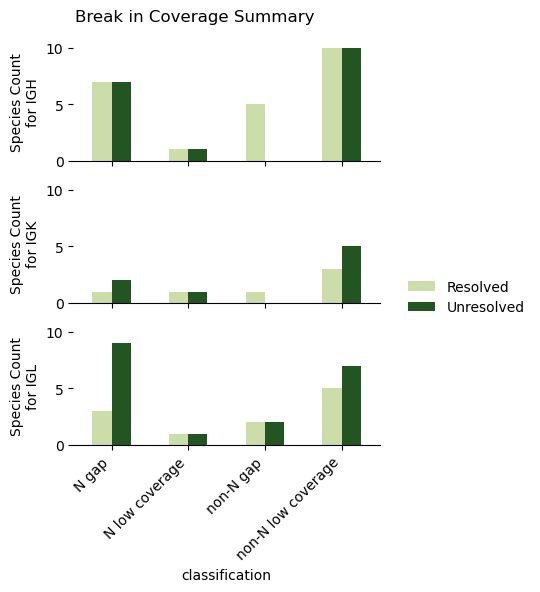

In [29]:
def plot_classification_counts(df, ax, title):
    # Count classification for resolved and unresolved haplotypes
    resolved_counts = df[df['Haplotype Resolved'] == "Yes"].groupby('classification')['Species'].nunique()
    unresolved_counts = df[df['Haplotype Resolved'] == "No"].groupby('classification')['Species'].nunique()
    
    # Create a DataFrame to combine the counts
    counts_df = pd.DataFrame({'Resolved': resolved_counts, 'Unresolved': unresolved_counts}).fillna(0)
    
    # Plot the counts
    counts_df.plot(kind='bar', ax=ax, color=['#CCDDAA', '#225522'])
    #ax.set_title(title, fontsize=10)
    ax.set_ylabel(f'Species Count\nfor {title}')
    ax.set_xticklabels(counts_df.index, rotation=45, ha='right')
    ax.legend().set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)

    
# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(4, 6), sharey=True, sharex=True)

# Plot each DataFrame
plot_classification_counts(igh_meta, axes[0], 'IGH')
plot_classification_counts(igk_meta, axes[1], 'IGK')
plot_classification_counts(igl_meta, axes[2], 'IGL')
handles, labels = axes[2].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
fig.suptitle('Break in Coverage Summary', fontsize=12)

# Adjust layout to make room for the legend
plt.tight_layout()
plt.savefig('../break/summaryBreak.png', format="png", dpi=300, bbox_inches='tight')

plt.show()